##### aimldl >python3 > packages > tensorflow > tutorials > beginners > 1_3_2-text_classification_with_preprocessed_text-IMDB.ipynb

* This notebook is a replica of [Text classification with preprocessed text: Movie reviews](https://www.tensorflow.org/tutorials/keras/text_classification) with some comments.
  * [TensorFlow](https://www.tensorflow.org/) > [Learn](https://www.tensorflow.org/learn) > [TensorFlow Core](https://www.tensorflow.org/overview) > [Tutorials](https://www.tensorflow.org/tutorials) > ML basics with Keras > [Text classification with preprocessed text](https://www.tensorflow.org/tutorials/keras/text_classification)
* It is prerequisite to install TensorFlow 2.0 & Keras.

# Text classification with preprocessed text: Movie reviews

This notebook classifies movie reviews as positive or negative using the text of the review. This is an example of binary—or two-class—classification, an important and widely applicable kind of machine learning problem.

The tutorial demonstrates the basic application of transfer learning with TensorFlow Hub and Keras.

We'll use the IMDB dataset that contains the text of 50,000 movie reviews from the Internet Movie Database. These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are balanced, meaning they contain an equal number of positive and negative reviews.

* The difference with [1_3_1-text_classification_with_TF_Hub-IMDB.ipynb](#1_3_1-text_classification_with_TF_Hub-IMDB.ipynb) is:
  * Encoder is used:
    * encoder = info.features['text'].encoder

### Prerequisite: Install tensorflow-datasets

In [1]:
!pip install -q tensorflow-datasets

### Setup / Import Modules

In [59]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

print("Version: ", tf.__version__)
#print("Eager mode: ", tf.executing_eagerly())
#print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")
tfds.disable_progress_bar()

Version:  2.0.0


### Download the IMDB dataset
Refer to [1_3_1-text_classification_with_TF_Hub.ipynb](#1_3_1-text_classification_with_TF_Hub.ipynb) which explains tfds.load and the options except with_info. If with_info is True, tfds.load returns the tuple of (tf.data.Dataset, tfds.core.DatasetInfo).

In [3]:
(train_data, test_data), info = tfds.load(
    # Use the version pre-encoded with an ~8k vocabulary.
    'imdb_reviews/subwords8k', 
    # Return the train/test datasets as a tuple.
    split = (tfds.Split.TRAIN, tfds.Split.TEST),
    # Return (example, label) pairs from the dataset (instead of a dictionary).
    as_supervised=True,
    # Also return the `info` structure. 
    with_info=True)

The last message specifies the location of the downloaded data:
> Dataset imdb_reviews downloaded and prepared to /home/aimldl/tensorflow_datasets/imdb_reviews/subwords8k/0.1.0

Notice name='imdb_reviews' is saved to
> /home/aimldl/tensorflow_datasets/imdb_reviews/plain_text/0.1.0

### Try the encoder
"info" has a lot of information.

In [7]:
info

tfds.core.DatasetInfo(
    name='imdb_reviews',
    version=0.1.0,
    description='Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.',
    urls=['http://ai.stanford.edu/~amaas/data/sentiment/'],
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(None,), dtype=tf.int64, encoder=<SubwordTextEncoder vocab_size=8185>),
    }),
    total_num_examples=100000,
    splits={
        'test': 25000,
        'train': 25000,
        'unsupervised': 50000,
    },
    supervised_keys=('text', 'label'),
    citation="""@InProceedings{maas-EtAl:2011:ACL-HLT2011,
      author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Potts

In [8]:
type( info )

tensorflow_datasets.core.dataset_info.DatasetInfo

In [11]:
info.features('name')

TypeError: 'FeaturesDict' object is not callable

The dataset info includes the text encoder (tfds.features.text.SubwordTextEncoder).

In [14]:
encoder = info.features['text'].encoder
type( encoder )

tensorflow_datasets.core.features.text.subword_text_encoder.SubwordTextEncoder

In [15]:
encoder

<SubwordTextEncoder vocab_size=8185>

In [16]:
print ('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


### Examples to Encode & Decode a Text
An example text is encoded and decoded. Note the decoded string is the same as the input string.

In [27]:
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print ('Sample string is {}'.format(sample_string))
print ('Encoded string is {}'.format(encoded_string))

decoded_string = encoder.decode(encoded_string)
print ('The decoded string: "{}"'.format(decoded_string))

assert decoded_string == sample_string

Sample string is Hello TensorFlow.
Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The decoded string: "Hello TensorFlow."


In [28]:
for ts in encoded_string:
  print ('{} ----> {}'.format(ts, encoder.decode([ts])))

4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


Another example is presented and this input is decoded correctly because all the vocabulary in the input string is within the range of the encoder's vocabulary.

In [19]:
input_string = 'Another sentence is added here'

encoded_string = encoder.encode(input_string)
decoded_string = encoder.decode(encoded_string)

print ('Input string is {}'.format(input_string))
print ('Encoded string is {}'.format(encoded_string))
print ('The decoded string: "{}"'.format(decoded_string))

Input string is Another sentence is added here
Encoded string is [1646, 7745, 7961, 9, 2843, 286]
The decoded string: "Another sentence is added here"


"Kiwi" is a rarely used word. Let's see how this can be encoded.

In [22]:
input_string = 'Kiwi is a bird which can not fly. So it exticnted when human showed up.'

encoded_string = encoder.encode(input_string)
decoded_string = encoder.decode(encoded_string)

print ('Input string is {}'.format(input_string))
print ('Encoded string is {}'.format(encoded_string))
print ('The decoded string: "{}"'.format(decoded_string))

Input string is Kiwi is a bird which can not fly. So it exticnted when human showed up.
Encoded string is [2051, 1060, 7961, 9, 4, 4698, 7961, 73, 83, 33, 8031, 124, 3, 392, 15, 2769, 586, 6124, 72, 607, 2289, 306, 7975]
The decoded string: "Kiwi is a bird which can not fly. So it exticnted when human showed up."


Surprisingly, this word is also encoded while the vocabulary size is as small as 8185. Why?
> The encoder encodes the string by breaking it into subwords or characters if the word is not in its dictionary. So the more a string resembles the dataset, the shorter the encoded representation will be.

In [23]:
input_string = 'Kiwi'

encoded_string = encoder.encode(input_string)
decoded_string = encoder.decode(encoded_string)

print ('Input string is {}'.format(input_string))
print ('Encoded string is {}'.format(encoded_string))
print ('The decoded string: "{}"'.format(decoded_string))

Input string is Kiwi
Encoded string is [2051, 1060]
The decoded string: "Kiwi"


In [26]:
print ('[2051] is: "{}"'.format( encoder.decode([2051]) ))
print ('[1060] is: "{}"'.format( encoder.decode([1060]) ))

[2051] is: "Ki"
[1060] is: "wi"


### Explore the data
#### 0 -> Negative & 1 -> Positive
The label is either 0 or 1 where 0 is a negative review and 1 is a positive review. 

In [29]:
for train_example, train_label in train_data.take(1):
  print('Encoded text:', train_example[:10].numpy())
  print('Label:', train_label.numpy())

Encoded text: [ 249    4  277  309  560    6 6639 4574    2   12]
Label: 1


In [30]:
train_data.take(1)

<TakeDataset shapes: ((None,), ()), types: (tf.int64, tf.int64)>

In [37]:
train_example[:10]

<tf.Tensor: id=12385, shape=(10,), dtype=int64, numpy=array([ 249,    4,  277,  309,  560,    6, 6639, 4574,    2,   12])>

In [43]:
train_example[:10].numpy()

array([ 249,    4,  277,  309,  560,    6, 6639, 4574,    2,   12])

In [38]:
train_label

<tf.Tensor: id=133, shape=(), dtype=int64, numpy=1>

In [33]:
encoder.decode(train_example[:10])

'As a lifelong fan of Dickens, I '

In [36]:
train_example

<tf.Tensor: id=132, shape=(855,), dtype=int64, numpy=
array([ 249,    4,  277,  309,  560,    6, 6639, 4574,    2,   12,   31,
       7759, 3525, 2128,   93, 2306,   43, 2312, 2527,    6,   30, 1334,
       8044,   24,   10,   16,   10,   17,  977,   30,  815, 3339,   41,
        841, 7911,  376, 7974, 1923,    6,  607,  219,   44,  242, 1603,
         11, 4329,  102, 2821, 1139,    2,  969,  161,   51,   18,    4,
       5844, 2820,  123, 4493,   40,    6, 4571,   13,  117,   35,  289,
        850,  455,   50,  460, 6359, 1069,  343,   20,    1, 3733, 3511,
       7670,    3,  147,    4,  336,    2,   42,   18,    4, 3422,  409,
       3533,  871, 2836,  311,    5, 5080, 1209,    3,  183,  117,   35,
       1187,    5, 1955,   11,    1,  226, 7745,    3,  183, 1466, 7359,
       7961, 1466,  665,    2, 6854, 3178, 1377, 6266, 1447,  297,    2,
       5797,   36, 4740,  847, 8050,    2,    5, 1929, 1631, 5986,   22,
       5541, 5688,    5, 1036, 3746, 8050,    3,   69,  264,   35,    

In [34]:
encoder.decode( train_example )

"As a lifelong fan of Dickens, I have invariably been disappointed by adaptations of his novels.<br /><br />Although his works presented an extremely accurate re-telling of human life at every level in Victorian Britain, throughout them all was a pervasive thread of humour that could be both playful or sarcastic as the narrative dictated. In a way, he was a literary caricaturist and cartoonist. He could be serious and hilarious in the same sentence. He pricked pride, lampooned arrogance, celebrated modesty, and empathised with loneliness and poverty. It may be a cliché, but he was a people's writer.<br /><br />And it is the comedy that is so often missing from his interpretations. At the time of writing, Oliver Twist is being dramatised in serial form on BBC television. All of the misery and cruelty is their, but non of the humour, irony, and savage lampoonery. The result is just a dark, dismal experience: the story penned by a journalist rather than a novelist. It's not really Dickens

Can you read the review and see if this review is positive? The review starts off from disappointment, but ends up giving 10 points. So this review is positive of which label is 1.

### Prepare the data for training
> You will want to create batches of training data for your model. The reviews are all different lengths, so use padded_batch to zero pad the sequences while batching:

In [46]:
BUFFER_SIZE = 1000
train_batches = ( train_data
                  .shuffle(BUFFER_SIZE)
                  .padded_batch(32, train_data.output_shapes))

test_batches = ( test_data
                 .padded_batch(32, train_data.output_shapes))

In [47]:
for example_batch, label_batch in train_batches.take(2):
  print("Batch shape:", example_batch.shape)
  print("label shape:", label_batch.shape)

Batch shape: (32, 1283)
label shape: (32,)
Batch shape: (32, 971)
label shape: (32,)


There are 32 labels in the first batch which is specified by ".padded_batch(32, ...)".

In [51]:
for example_batch, label_batch in train_batches.take(1):
    print( len( label_batch) )
    print( label_batch )

32
tf.Tensor([1 1 0 1 1 1 0 1 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 1 0 0 0 1 0 0 0 1], shape=(32,), dtype=int64)


Like the number of labels, there are 32 examples in the first batch. The length of each example is 974. Each token is encoded to an integer. Note an example with less number of tokens than 974 is padded with zero.

In [56]:
for example_batch, label_batch in train_batches.take(1):
    print( len( example_batch) )
    print( example_batch.shape )
    print( example_batch[0] )
    print( example_batch[1] )

32
(32, 974)
tf.Tensor(
[ 133  366    7  210   32   73 1925 3639   25    1  176 5844 2820  123
 6200 6291 7961    6 4928 5371 1817 3827  807 2631 7961   20    4 1786
 3131 7961 2240    3 2294  428   28   20 3760   58  511    4 4457   26
 7544  551  770 1529 2896  350 2393    6    1 2755 2002 6800  102 4928
 3185    2    1 3533  871 1337 3827  807 2631 7961  143  253   20    1
  213  204    3 2654 2354 8033    2   20 1060   64 3477   47 5658 7961
 6878 1231 3202 8033    2   46 2005  957  462 3827  807 2631 7961   44
    1 3477   47 4090 2309   11 2782 7981    2    9   67  248    2   20
 5995   24   10   16   10   17  147  823    2 3827  807 2631 7961    5
  814 7148 7961   85  236  335   11 3696 1267   60    1 3444 7887 7644
  353 2583   11    1 3477 8050    2    5    1 2782  764 3477   47 4090
 2309 1436  413 3721 4620   11    1 4472 3354 3115  102  427   43    1
 3477   47    7 1962 4689 7961    1 6058   25  385   48   79 7644  353
 3214 3052    2   73    1 3803 5066 7961   85 6058  2

### Build the model
> The neural network is created by stacking layers—this requires two main architectural decisions:

* How many layers to use in the model?
* How many hidden units to use for each layer?
> In this example, the input data consists of an array of word-indices. The labels to predict are either 0 or 1. Let's build a "Continuous bag of words" style model for this problem:

Caution: This model doesn't use masking, so the zero-padding is used as part of the input, so the padding length may affect the output. To fix this, see the masking and padding guide.

In [60]:
model = keras.Sequential([
  keras.layers.Embedding(encoder.vocab_size, 16),
  keras.layers.GlobalAveragePooling1D(),
  keras.layers.Dense(1, activation='sigmoid')])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 130,977
Trainable params: 130,977
Non-trainable params: 0
_________________________________________________________________


Recall the dimension of example_batch is (32, 974) which is (batch, sequence). The embedding layer adds another dimension for embedding. As a result, (batch, sequence, embedding) is the resulting dimensions.

The source codes of the previous example [1_3_1-text_classification_with_TF_Hub.ipynb](#1_3_1-text_classification_with_TF_Hub.ipynb] is compared below.
```python
model = tf.keras.Sequential()
model.add( hub_layer )
model.add( tf.keras.layers.Dense(16, activation='relu') )
model.add( tf.keras.layers.Dense(1, activation='sigmoid') )
```

### Hidden units
### Loss function and optimizer
> Generally, binary_crossentropy is better for dealing with probabilities—it measures the "distance" between probability distributions, or in our case, between the ground-truth distribution and the predictions.

In [61]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Note the output shape of the embeddings is fixed to (num_examples, embedding_dimension) regardless of the input text length.

### Train the model

In [62]:
history = model.fit(train_batches,
                    epochs=10,
                    validation_data=test_batches,
                    validation_steps=30)

Epoch 1/10
782/782 [==============================] - 3s 4ms/step - loss: 0.6826 - accuracy: 0.6312 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
782/782 [==============================] - 2s 3ms/step - loss: 0.6255 - accuracy: 0.7469 - val_loss: 0.5970 - val_accuracy: 0.7906
Epoch 3/10
782/782 [==============================] - 2s 3ms/step - loss: 0.5464 - accuracy: 0.8065 - val_loss: 0.5306 - val_accuracy: 0.8042
Epoch 4/10
782/782 [==============================] - 2s 3ms/step - loss: 0.4784 - accuracy: 0.8410 - val_loss: 0.4775 - val_accuracy: 0.8500
Epoch 5/10
782/782 [==============================] - 2s 3ms/step - loss: 0.4260 - accuracy: 0.8609 - val_loss: 0.4361 - val_accuracy: 0.8583
Epoch 6/10
782/782 [==============================] - 2s 3ms/step - loss: 0.3842 - accuracy: 0.8760 - val_loss: 0.4036 - val_accuracy: 0.8583
Epoch 7/10
782/782 [==============================] - 2s 3ms/step - loss: 0.3519 - accuracy: 0.8849 - val_loss: 0.3779 - val_accuracy: 0.867

### Create a graph of accuracy and loss over time
The four performance metric (loss, accuracy, val_loss, val_accuracy) is harder to understand than a graph. In this section, these four quantities are depicted in two graphs.

> model.fit() returns a History object that contains a dictionary with everything that happened during training. history_dict contains the same performance metric displayed in the command line above: 

In [64]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

The following variables save the four quantities: training accuracy, validation accuracy, training loss, and validation loss.

In [65]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

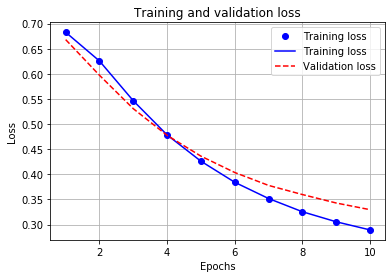

In [74]:
import matplotlib.pyplot as plt
%matplotlib inline
epochs = range(1, len(acc) + 1)

# Loss plot
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, loss, 'b', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'r--', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

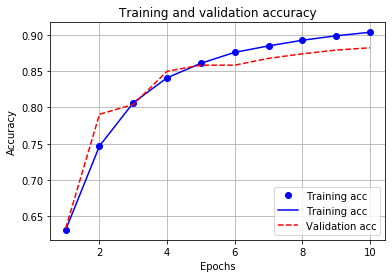

In [75]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r--', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid()

plt.show()

* Excerpt from the tutorial

Notice the training loss decreases with each epoch and the training accuracy increases with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.

This isn't the case for the validation loss and accuracy—they seem to peak after about twenty epochs. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations specific to the training data that do not generalize to test data.

For this particular case, we could prevent overfitting by simply stopping the training after twenty or so epochs. Later, you'll see how to do this automatically with a callback.

### Evaluate the model

In [63]:
loss, accuracy = model.evaluate(test_batches)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 1s 2ms/step - loss: 0.3332 - accuracy: 0.8776
Loss:  0.33321987750851895
Accuracy:  0.8776


> This fairly naive approach achieves an accuracy of about 87%. With more advanced approaches, the model should get closer to 95%.

The source codes in the previous eaxmple is presented below for comparison.
```python
results = model.evaluate( test_data.batch(512), verbose=2 )

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))
```

> This fairly naive approach achieves an accuracy of about 87%. With more advanced approaches, the model should get closer to 95%.

(EOF)